In [170]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append("..")
import src.utility.plot_settings

## Quickstart

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

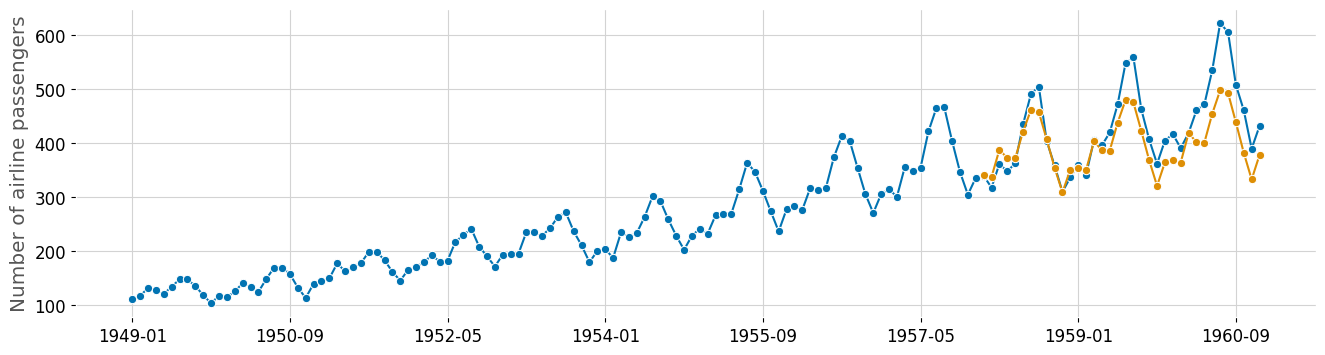

In [169]:
# https://www.sktime.org/en/stable/get_started.html

y = load_airline()
y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)
plot_series(y, y_pred)

## Traffic data

In [171]:
# https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
traffic = pd.read_csv("../data/raw/traffic.csv", parse_dates=[0], index_col=[0])

# Pivot data
traffic = traffic.pivot(columns="Junction", values="Vehicles")

In [175]:
traffic

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


<AxesSubplot: xlabel='DateTime'>

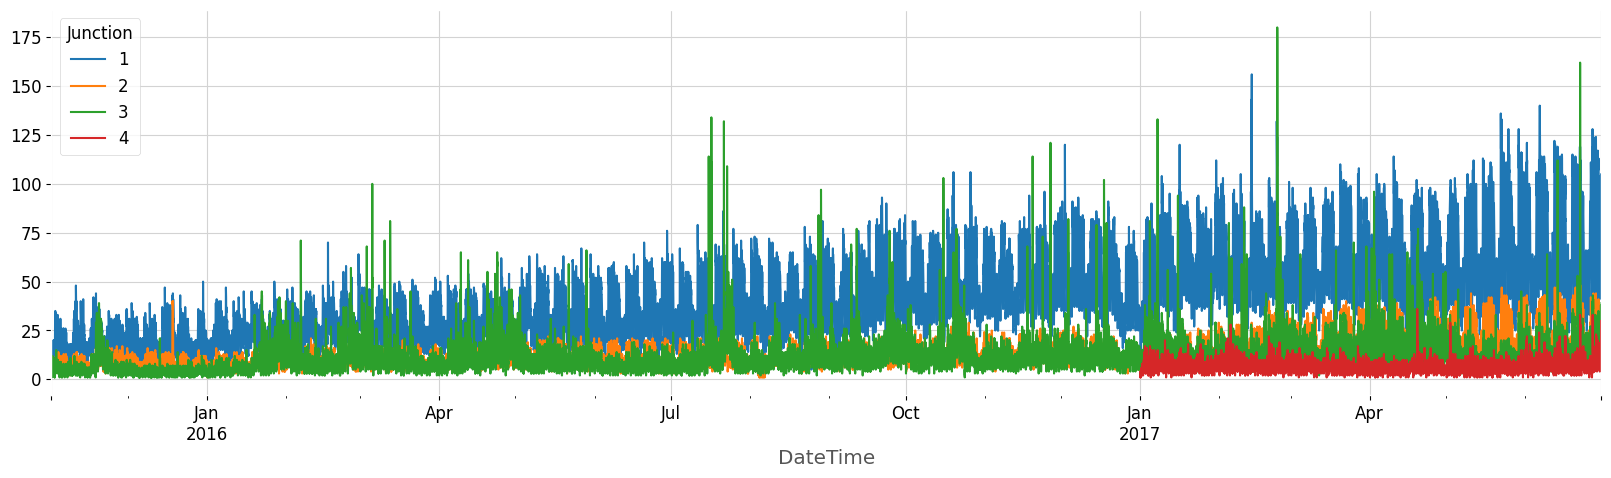

In [176]:
traffic.plot()

## Forecasting with sktime

In [173]:

def prophet_forecast(dataset, horizon, forecaster, validation=False, confidence=0.9, frequency="D"):

    forecast_df = dataset.resample(rule=frequency).sum()

    # Interpolate missing periods (if any)
    forecast_df = forecast_df.interpolate(method="time")

    forecaster = forecaster

    for col in dataset.columns:

        if validation:
            df = forecast_df[col]

            y_train = df[:-horizon]
            y_test = df.tail(horizon)

            forecaster.fit(y_train)
            fh = ForecastingHorizon(y_test.index, is_relative=False)
            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            y_true = df.tail(horizon)

            mae = mean_absolute_error(y_true, y_pred)

        if not validation:
            df = forecast_df[col].dropna()
            forecaster.fit(df)

            last_date = df.index.max()
            fh = ForecastingHorizon(
                pd.date_range(str(last_date), periods=horizon, freq=frequency),
                is_relative=False,
            )

            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            mae = np.nan

        plt.plot(
            df.tail(horizon * 3),
            label="Actual",
            color="black",
        )
        plt.gca().fill_between(
            ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color="b", alpha=0.1
        )
        plt.plot(y_pred, label="Predicted")
        plt.title(
            f"{horizon} day forecast for {col} (mae: {round(mae, 2)}, confidence: {confidence*100}%)"
        )
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
        plt.show()

11:11:24 - cmdstanpy - INFO - Chain [1] start processing
11:11:24 - cmdstanpy - INFO - Chain [1] done processing


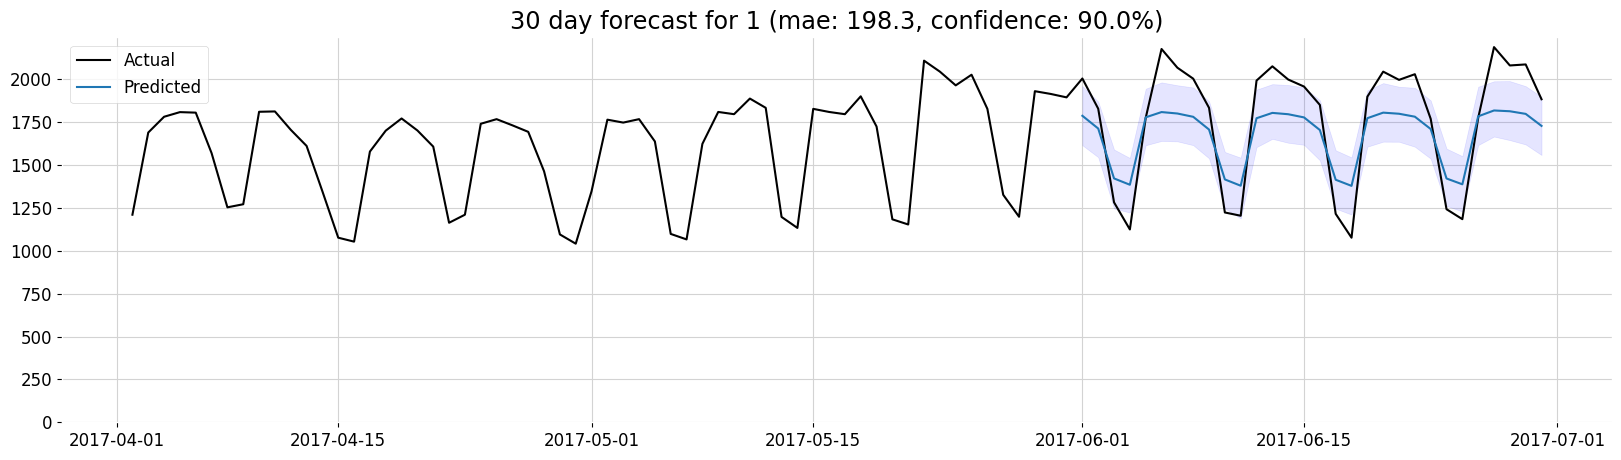

11:11:25 - cmdstanpy - INFO - Chain [1] start processing
11:11:25 - cmdstanpy - INFO - Chain [1] done processing


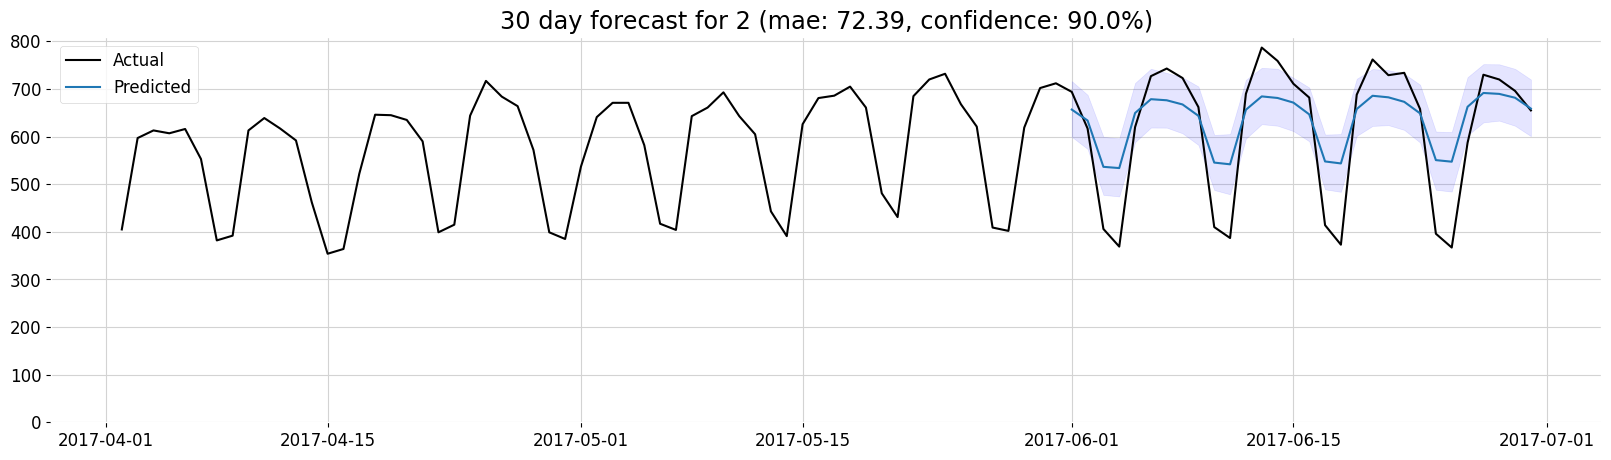

11:11:26 - cmdstanpy - INFO - Chain [1] start processing
11:11:26 - cmdstanpy - INFO - Chain [1] done processing


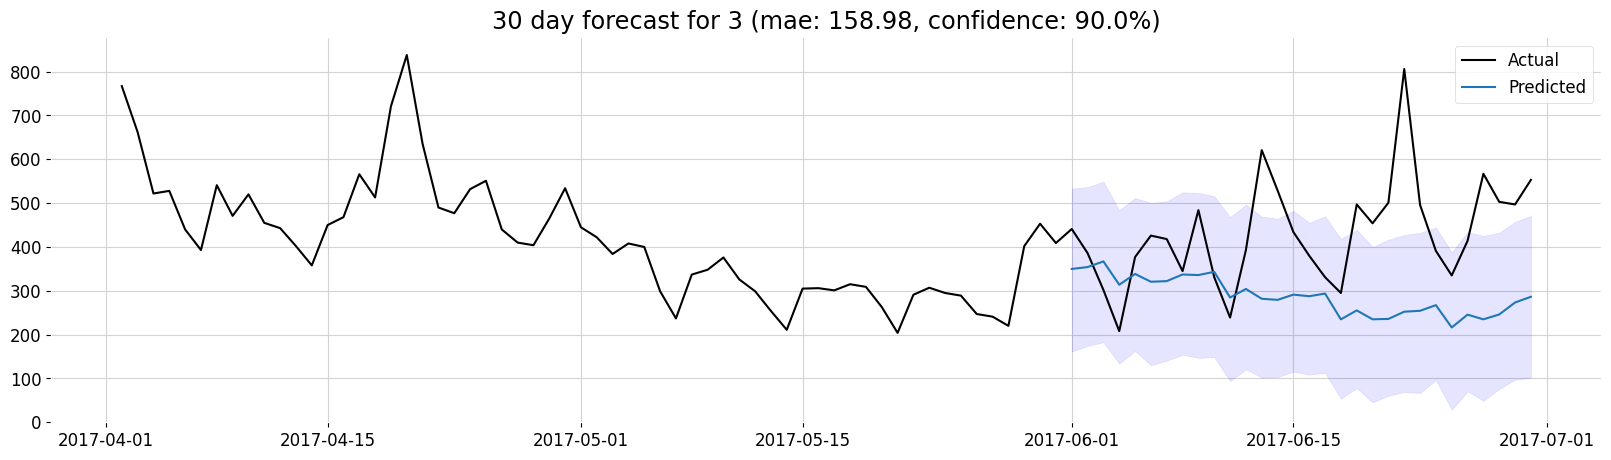

11:11:26 - cmdstanpy - INFO - Chain [1] start processing
11:11:26 - cmdstanpy - INFO - Chain [1] done processing


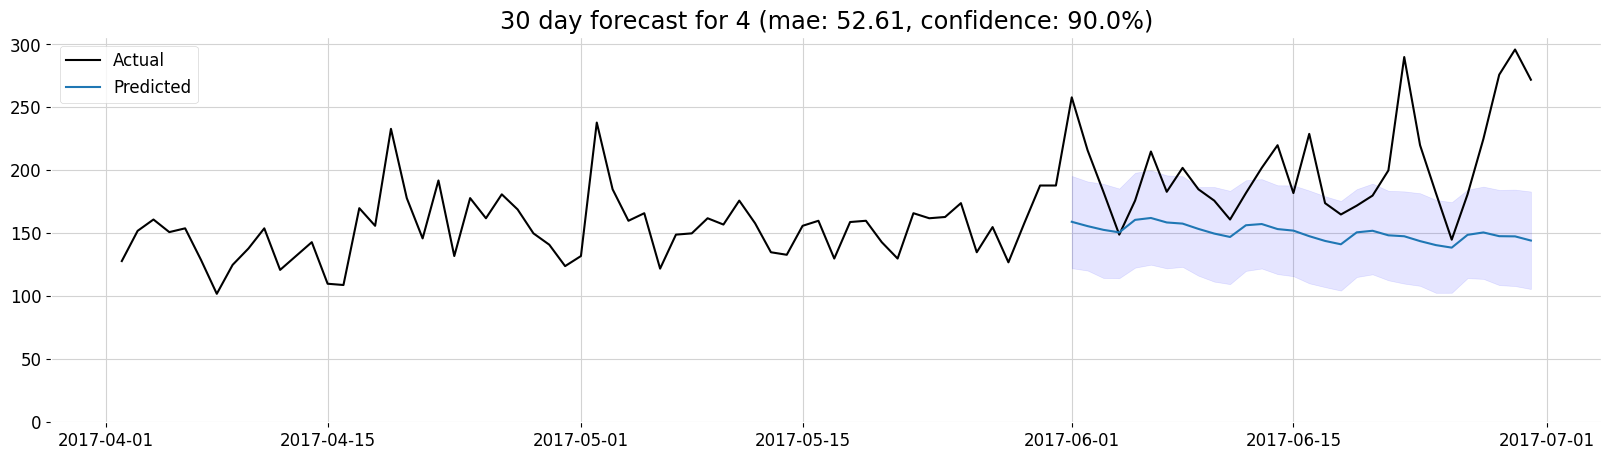

In [174]:
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet_forecast(traffic, horizon=30, forecaster=forecaster, validation=True, frequency="D")

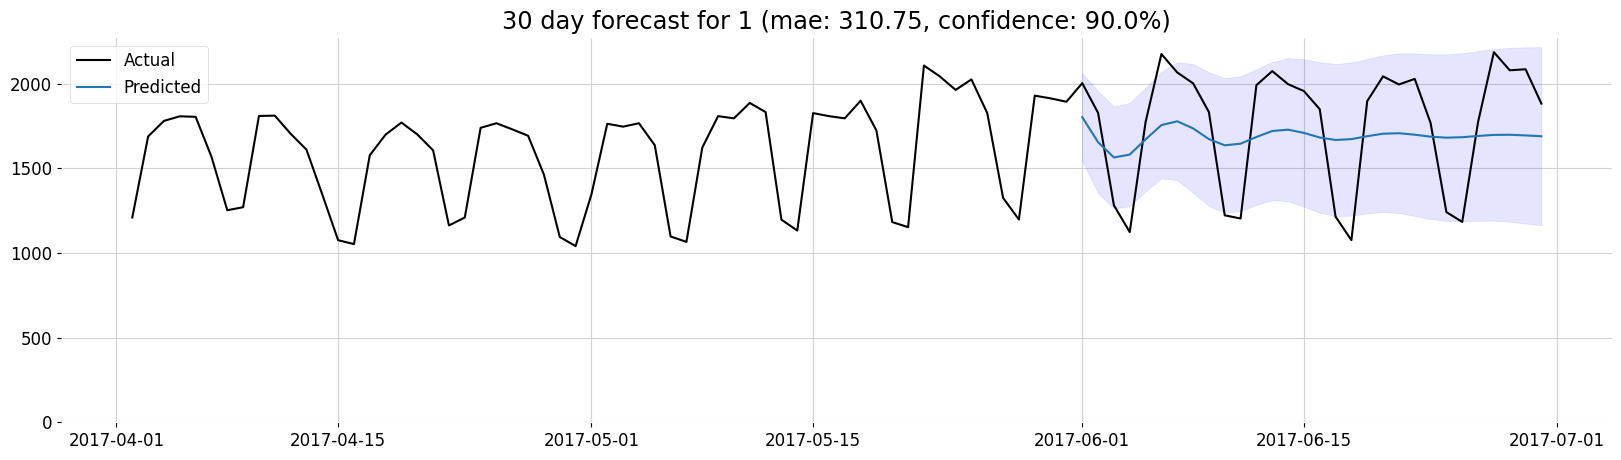

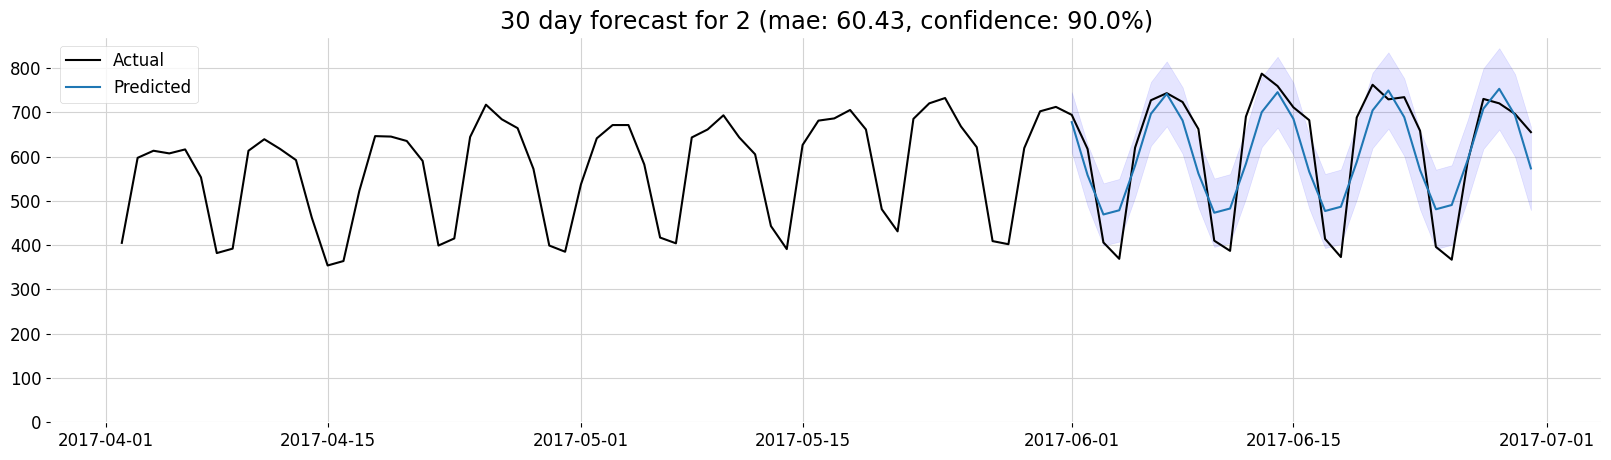

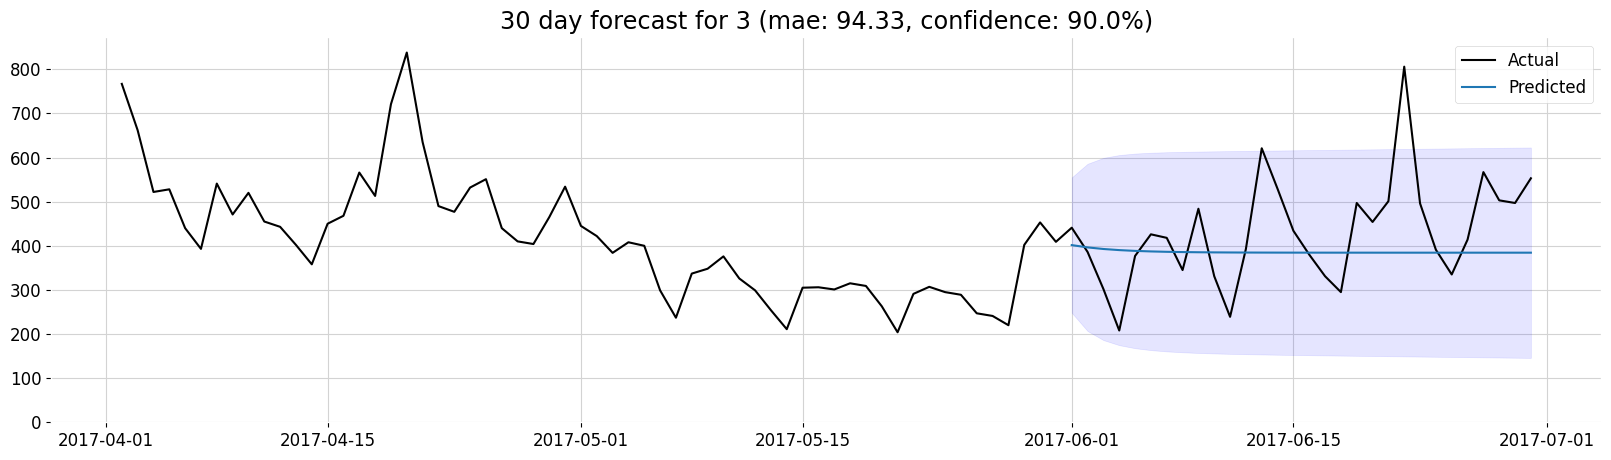

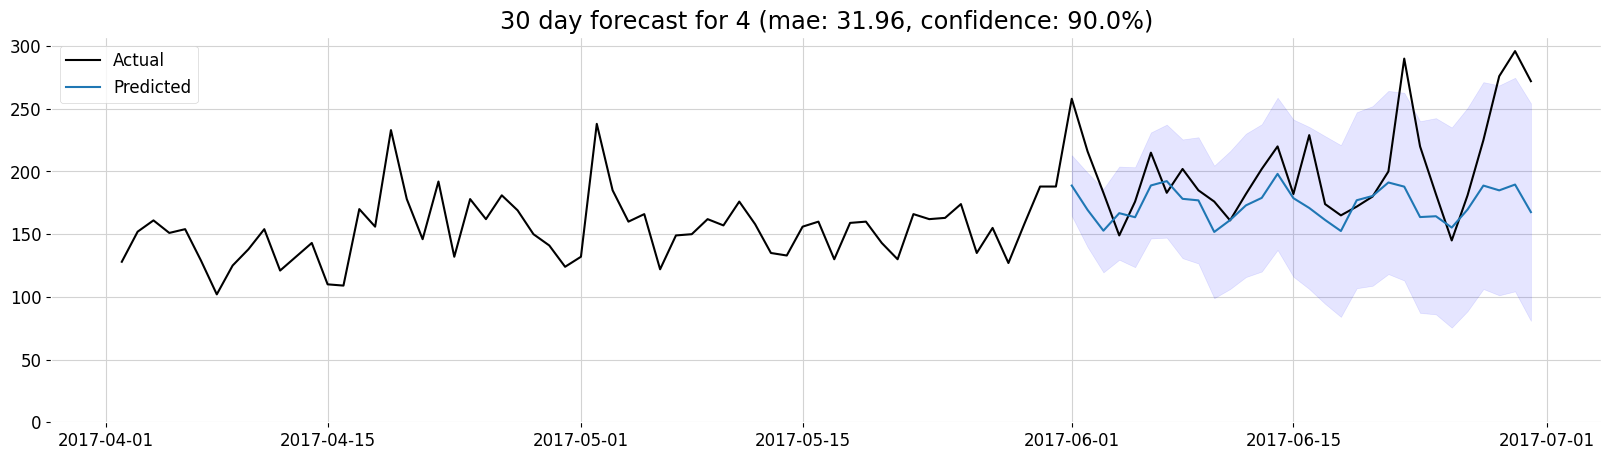

In [178]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
prophet_forecast(traffic, horizon=30, forecaster=forecaster, validation=True, frequency="D")